# Desafío N° 1 - Data Wrangling

Esta notebook va a llevar a adelante el Desafío N° 1 del curso de DataScience sobre un dataset correspondiente a la web Properati donde se publican inmuebles de todo el país

In [24]:
# En primer lugar importamos las librerias con las que vamos a trabajar a lo largo del proyecto

import pandas as pd
import numpy as np
import seaborn as sns
import re
import scipy

In [8]:
# Es necesario importar el dataset con el cual vamos a trabajar

file_path = "properati.csv"
data = pd.read_csv(file_path, sep = ",")
print(data.shape)
data.head(2)

(121220, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [9]:
data.dtypes.value_counts()

float64    13
object     12
int64       1
dtype: int64

Se observa que el dataset cuenta con 121000 observaciones y 26 variables, de las cuales 13 son numeros reales, 12 son strings y 1 es un entero (esta igual debemos removerla ya que se trata de un indice innecesario)

In [10]:
# Procedemos a remover la primer columna del dataset
data = data.iloc[:,1:]
data.head(2)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [11]:
# Algo interesante para mirar sería el tipo de dato que tiene cada variable

print(data.dtypes)
print("\n")

# Y también ver como se distribuyen los datos que son numericos
data.info()

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object


<class 'pandas.core.frame.DataFram

Se ve que hay algunas columnas que parecen no aportar mucha información al dataset, mas bien redundan basadas en otras columnas
En este sentido esto va en contra de la idea de "tidy data".
Sería una buena idea remover estas columnas

Por otro lado hay columnas muy poco relevantes como por ejemplo el URL de la publicación o el URL de las fotos presentes en el dataset. A simple vista se ve que esto no puede ser manejado por ningún modelo predictivo.
También seria relevanete remover estas columnas

In [12]:
data.drop(['place_with_parent_names', 'lat-lon'], axis = 1, inplace= True)
data.drop(['properati_url', 'image_thumbnail'], axis = 1, inplace= True)

## Análisis sobre CABA

Dado que el dataset es sustancialemnte grande y con gran variabilidad en la completitud de los datos, decidimos enfocar nuestro análisis sobre una región en particular: Capital Federal, ya que es la región que aglomera la mayor cantidad de publicaciones

In [13]:
data.state_name.value_counts().head(4)

Capital Federal             32316
Bs.As. G.B.A. Zona Norte    25560
Bs.As. G.B.A. Zona Sur      13952
Córdoba                     12069
Name: state_name, dtype: int64

In [85]:
states = ["Capital Federal"]

mask = [(x in states) for x in data.state_name]

data2 = data.loc[mask,:]
data2.sample(3)

,operation,property_type,place_name,country_name,state_name,geonames_id,lat,lon,price,currency,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
35437,sell,apartment,Palermo Hollywood,Argentina,Capital Federal,NaN,-34.577306,-58.437252,74000.0,USD,...,74000.0,29.0,29.0,2551.724138,2551.724138,2.0,1.0,1900.0,"STUDIO en Soler 6000, Palermo Hollywood, CAPIT...",DEPARTAMENTO EN VENTA
86644,sell,apartment,Villa Urquiza,Argentina,Capital Federal,3433775.0,NaN,NaN,NaN,NaN,...,NaN,40.0,31.0,NaN,NaN,NaN,NaN,NaN,BBU2956 AP211293,OLAZABAL Y TRIUNVIRATO
27116,sell,apartment,Palermo,Argentina,Capital Federal,3430234.0,-34.589350,-58.408060,235000.0,USD,...,235000.0,83.0,83.0,2831.325301,2831.325301,NaN,NaN,4500.0,CODIGO: 0 ubicado en: S.BUSTAMANTE 1900 - Pub...,Bustamante 1900 - 4 Amb C/dep. Contrafrente Si...


# OUTLIERS

In [97]:
# Superfice cubierta en m2
# maximo = data2.surface_covered_in_m2.max()
# data2['surface_covered_in_m2'] = data2.surface_covered_in_m2.replace(maximo, np.NaN)

remplazo = data2[(data2.property_type == 'apartment') & (data2.surface_covered_in_m2 > 2000)].surface_covered_in_m2 / 100

prueba = pd.merge(data2, remplazo, right_index= True, left_index= True, suffixes=("","_new"), how = 'left')
prueba

data2['surface_covered_in_m2'] = prueba.surface_covered_in_m2_new.fillna(prueba.surface_covered_in_m2)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:xlabel='surface_covered_in_m2', ylabel='property_type'>

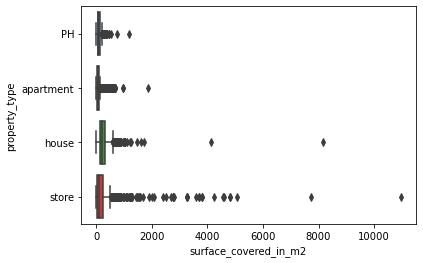

In [98]:
sns.boxplot(x = data2.surface_covered_in_m2, y = data2.property_type)

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<AxesSubplot:xlabel='surface_total_in_m2', ylabel='property_type'>

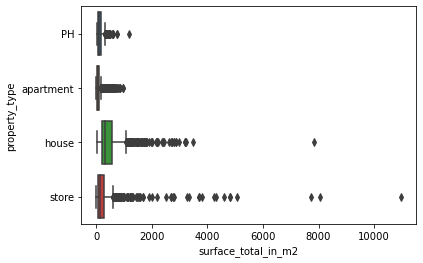

In [104]:
# maximo = data2.surface_total_in_m2.max()
# data2['surface_total_in_m2'] = data2.surface_total_in_m2.replace(maximo, np.NaN)

remplazo = data2[(data2.property_type == 'apartment') & (data2.surface_total_in_m2 > 2000)].surface_total_in_m2 / 100

prueba = pd.merge(data2, remplazo, right_index= True, left_index= True, suffixes=("","_new"), how = 'left')
prueba

data2['surface_total_in_m2'] = prueba.surface_total_in_m2_new.fillna(prueba.surface_total_in_m2)

sns.boxplot(data2.surface_total_in_m2, data2.property_type)

<AxesSubplot:ylabel='property_type'>

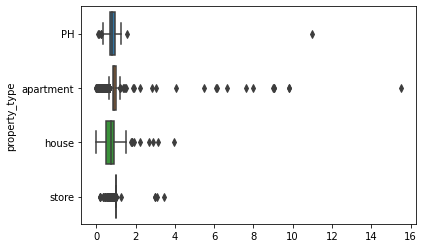

In [109]:
por_sup_cubierta = data2.surface_covered_in_m2/data2.surface_total_in_m2
por_sup_cubierta.describe()

sns.boxplot(x = por_sup_cubierta, y = data2.property_type)

In [111]:
data2[por_sup_cubierta > 3]

,operation,property_type,place_name,country_name,state_name,geonames_id,lat,lon,price,currency,...,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title,surface_covered_in_m2_otra
8924,sell,PH,Saavedra,Argentina,Capital Federal,3429422.0,-34.555993,-58.477914,250000.0,USD,...,10.0,110.0,25000.000000,2272.727273,NaN,NaN,NaN,CODIGO: 1974-597 ubicado en: Nuñez 3600 - Pub...,"PH 4 Amb. Patio, Toilet, Dep. muy luminoso.",110.0
9866,sell,store,Capital Federal,Argentina,Capital Federal,3433955.0,NaN,NaN,350000.0,USD,...,40.0,123.0,8750.000000,2845.528455,NaN,NaN,NaN,Local en EDIFICIO lomas Parck muy bien ubicado...,"Local 40m² con Plantas en Sucre, Av. 1600, Arg...",123.0
17397,sell,apartment,Coghlan,Argentina,Capital Federal,3435359.0,-34.557157,-58.479782,178000.0,USD,...,14.0,86.0,12714.285714,2069.767442,NaN,NaN,NaN,CODIGO: 1974-611 ubicado en: Washington 3500 -...,Dpto de 4 Amb. Contra frente con Balcon,86.0
21531,sell,apartment,Recoleta,Argentina,Capital Federal,3429595.0,-34.593267,-58.412733,330000.0,USD,...,10.0,155.0,33000.000000,2129.032258,NaN,NaN,12000.0,CODIGO: 1819-CON555 ubicado en: Billinghurst 1...,Billinghurst y Mansilla. Piso 165 m2. 4 Dorm. ...,155.0
33389,sell,store,Monserrat,Argentina,Capital Federal,3430570.0,-34.612402,-58.387897,390000.0,USD,...,106.0,363.0,3679.245283,1074.380165,NaN,NaN,NaN,"DISPOSICION: Al frente, 4 pisos con 20 habitac...",Venta PH c/20 habitaciones U$S 390.000 en More...,363.0
36888,sell,apartment,Palermo,Argentina,Capital Federal,3430234.0,NaN,NaN,250000.0,USD,...,13.0,79.0,19230.769231,3164.556962,1.0,NaN,NaN,Edificio ubicado sobre Scalabrini Ortiz entre ...,Departamento 13m² con Teléfono en Scalabrini O...,79.0
45764,sell,apartment,Palermo Hollywood,Argentina,Capital Federal,NaN,-34.573569,-58.438419,1759100.0,ARS,...,37.0,335.0,2773.332703,5251.044776,1.0,NaN,NaN,Excelente Monoambiente NUEVO en el moderno com...,Departamento 37m² con Plantas en Cabildo Av. 2...,335.0
45765,sell,apartment,Palermo Hollywood,Argentina,Capital Federal,NaN,-34.573569,-58.438419,1920000.0,ARS,...,37.0,335.0,3027.001622,5731.343284,7.0,NaN,NaN,Excelente Monoambiente NUEVO en el moderno com...,Departamento 37m² con Plantas en Cabildo Av. 2...,335.0
45774,sell,apartment,Villa Urquiza,Argentina,Capital Federal,3433775.0,-34.573217,-58.473208,6391756.0,ARS,...,121.0,965.0,3081.399339,6623.581347,6.0,NaN,NaN,DEPARTAMENTO EN VENTA HOLMBERG ON!FINANCIACIÃN...,Departamento 121m² con Plantas en Echeverria 4...,965.0
46473,sell,apartment,Belgrano,Argentina,Capital Federal,3436077.0,NaN,NaN,198000.0,USD,...,10.0,90.0,19800.000000,2200.000000,5.0,NaN,NaN,Edificio ubicado en la calle Sucre entre Av. d...,"Departamento 10m² con 6 Plantas en Sucre, Mcal...",90.0


0         1127.272727
2         1309.090909
3                 NaN
7                 NaN
8                 NaN
             ...     
121160            NaN
121209            NaN
121215            NaN
121217            NaN
121219    1675.324675
Name: price_usd_per_m2, Length: 32316, dtype: float64

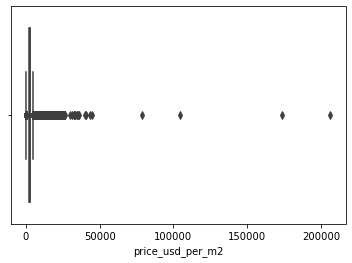

In [40]:
# Superfice cubierta en m2
sns.boxplot(data2.price_usd_per_m2)

mediana = data2.surface_covered_in_m2.median()
q25 = data2.price_usd_per_m2.describe().loc["25%"]
q75 = data2.price_usd_per_m2.describe().loc["75%"]
IQR = q75 - q25

sin_out = data2.price_usd_per_m2.apply(lambda x: np.NaN if ((x > mediana + IQR * 2) | (x < mediana - IQR * 2)) else x)
sin_out

C:\Users\franf\anaconda3\envs\dhdsblend_37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='price_usd_per_m2', ylabel='property_type'>

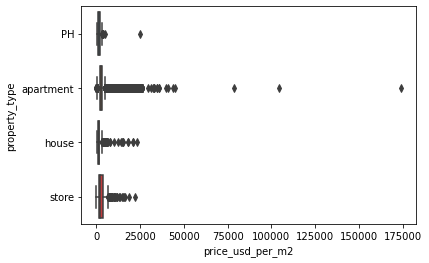

In [120]:
maximo = data2.price_usd_per_m2.max()
data2['price_usd_per_m2'] = data2.price_usd_per_m2.replace(maximo, np.NaN)

sns.boxplot(data2.price_usd_per_m2, data2.property_type)

## EDA - Missing Data

Un análisis que es importante realizar es la presencia de datos faltantes que tiene el dataset.
A simple vista se ve que muchas de las variables numércias tienen varios valores faltantes, es necesario identificar que % de la data representa y si sería posible tomar una decisión de imputación.

Viendo los resultados mostrados en el gráfico, se puede observar que hay algunas variables con un importante % de valore faltantes (superiores al 50% de los datos - "floor", "expensas", "rooms"). En principio generar algún método de imputación parece ser muy complejo. Contamos tanto con la descripción de la publicación y con el título de la misma, por lo que se podría implementar un método regex para extraer estos datos

Con el resto de las variables numéricas podría intentar realziarse una imputación:
1. lon, lat: en estas variables no tiene tanto sentido ya que dependen mucho de la ubicación del inmueble y solo contambos con el barrio/ciudad. En caso de querer imputarlas podrían manejarse dos opciones
        1.a. poner la lon, lat que sale del barrio en Google Maps
        1.b. buscar en las descripciones los nombres de las calles o la dirección y con API de GoogleMaps extraer lon, lat
        1.c. utilizar el dato de geonames para extraer la lat-lon y en los casos que falta completar con el promedio del barrio
2. price_USD_per_m2: esto no es más que un cálculo en base a otras variables que también tienen datos faltantes, de ser posible estimar las anteriores de podría completar en su totalidad
3. El resto de las variables con algunos de los mecanismos de imputación podrían resolverse

<AxesSubplot:>

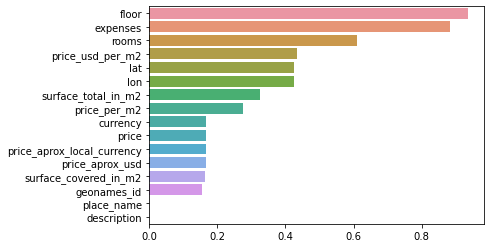

In [10]:
missing_data = data.isnull().sum(axis = 0) / data.shape[0]
missing_data.sort_values(inplace = True, ascending = False)
miss = missing_data[missing_data>0]

sns.barplot(y = miss.index, x = miss)

<AxesSubplot:>

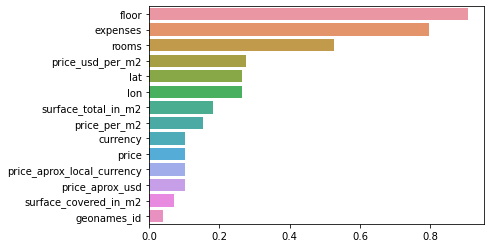

In [11]:
md2 = data2.isnull().sum(axis = 0) / data2.shape[0]
md2.sort_values(inplace = True, ascending = False)
miss2 = md2[md2>0]

sns.barplot(y = miss2.index, x = miss2)

En lineas generales Capital Federal y Bs.As. G.B.A. Zona Norte son las dos regiones que tienen menor cantidad de datos faltantes en cada una de las categorías de datos más importnates (precio, superficie, ambientes)

In [15]:
a = data.surface_covered_in_m2.isnull().groupby(data['state_name']).sum().sort_values(ascending = False)
b = pd.merge(a, data.state_name.value_counts(), left_index=True, right_index = True)
b["porcentaje_null"] = b.surface_covered_in_m2/b.state_name
b.porcentaje_null.sort_values().head()

Santiago Del Estero         0.000000
Bs.As. G.B.A. Zona Norte    0.069327
Capital Federal             0.072379
Corrientes                  0.125214
Bs.As. G.B.A. Zona Oeste    0.148251
Name: porcentaje_null, dtype: float64

## Adaptación de nombres

Para poder manejarnos más facil vamos a adaptar los nombres de las columnas

In [16]:
data2.columns
data2.columns = ['operacion', 'tipo_prop', 'barrio', 'pais', 'provincia', 'geoname', 'lat', 'lon', 
                 'precio', 'moneda', 'precio_pesos', 'precio_usd', 'sup_total', 'sup_cubierta', 'precio_usd_m2', 'precio_m2',
                'piso', 'ambientes', 'expensas', 'descripcion', 'titulo']

data2.columns

Index(['operacion', 'tipo_prop', 'barrio', 'pais', 'provincia', 'geoname',
       'lat', 'lon', 'precio', 'moneda', 'precio_pesos', 'precio_usd',
       'sup_total', 'sup_cubierta', 'precio_usd_m2', 'precio_m2', 'piso',
       'ambientes', 'expensas', 'descripcion', 'titulo'],
      dtype='object')

## Análisis del contenido de descripción y título

### Ambientes

In [18]:
# Con el metodo extract se puede ubicar el primer elemento de la cadena de texto que cumple la condición planteada
# En algunos casos, en la descripción aparecen menciones amuchos tipos de dptos ya que suelen ser desarrollos inmobiliarios
# Por eso priorizamos el dato que viene del titulo y si este no tiene, completamos con el primer dato de la descripcion

a = data2.descripcion.str.extract("(?P<amb>\d{1,2})\s*amb|(?P<mono>mono)\S*amb", flags = re.IGNORECASE)

a['mono'] = a.mono.replace(re.compile("mono", flags = re.IGNORECASE), "1")

a['ambientes'] = a.amb.fillna(a.mono).astype(float)


b = data2.descripcion.str.extract("(?P<amb>\d{1,2})\s*amb|(?P<mono>mono)\S*amb", flags = re.IGNORECASE)

b['mono'] = b.mono.replace(re.compile("mono", flags = re.IGNORECASE), "1")

b['ambientes'] = b.amb.fillna(b.mono).astype(float)


ambientes = b.ambientes.fillna(a.ambientes)

ambientes

,amb,mono,ambientes
0,2,NaN,2.0
2,2,NaN,2.0
3,3,NaN,3.0
7,NaN,1,1.0
8,NaN,NaN,NaN
...,...,...,...
121160,NaN,NaN,NaN
121209,NaN,NaN,NaN
121215,NaN,NaN,NaN
121217,NaN,1,1.0


In [19]:
data_ambientes = data2.join(ambientes, rsuffix="_nuevo")

data_ambientes['ambientes2'] = data_ambientes.ambientes_nuevo.fillna(data_ambientes.ambientes)
print(data_ambientes.ambientes2.isnull().sum())
data_ambientes.loc[:,['ambientes', 'ambientes_nuevo', 'ambientes2']].sample(10)

7604


,ambientes,ambientes_nuevo,ambientes2
22926,NaN,NaN,NaN
38512,2.0,NaN,2.0
95875,NaN,NaN,NaN
40380,2.0,NaN,2.0
116578,NaN,4.0,4.0
66766,NaN,3.0,3.0
9511,NaN,NaN,NaN
26382,1.0,1.0,1.0
75777,NaN,3.0,3.0
749,6.0,NaN,6.0


In [20]:
data = data_ambientes.drop(['ambientes', 'ambientes_nuevo'], axis = 1)
data = data.rename(columns = {'ambientes2': 'ambientes'})

### Piso del dpto

In [17]:
pisos = data.descripcion.str.extract("(\d)\s*er|(\d{1,2})\s*\wo|(\d)°|\s+(PB)\s+|(\w{5,10})\s+piso", flags = re.IGNORECASE)

pisos.iloc[:,3].value_counts()

pisos.iloc[:,3] = pisos.iloc[:,3].apply(lambda x: x if x is np.NaN else "0")

pisos.iloc[:,3].value_counts()

pisos['piso'] = pisos.iloc[:,0].fillna(pisos.iloc[:,1])
pisos['piso'] = pisos.piso.fillna(pisos.iloc[:,2])
pisos['piso'] = pisos.piso.fillna(pisos.iloc[:,3])

pisos.piso.value_counts()

2     4050
3     1676
1     1372
4      908
0      616
      ... 
89       1
48       1
59       1
76       1
88       1
Name: piso, Length: 103, dtype: int64

In [111]:
indice = ['primer', 'segundo', ' tercer', 'cuarto', 'quinto', 'sexto', 'ptimo', 'octavo', 'noveno']
numero = [1,2,3,4,5,6,7,8,9]

for pis,numero in zip(indice,numero):
    a = pisos.iloc[:,4].str.contains(pis, flags = re.IGNORECASE)
    b = a.apply(lambda x: numero if x is True else np.NaN)
    c = c.fillna(b)

pisos['piso'] = pisos.piso.fillna(c)
pisos['piso'] = pisos.piso.astype(float)

<AxesSubplot:xlabel='piso'>

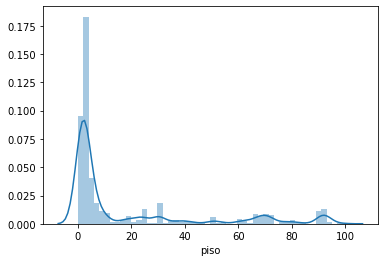

In [116]:
sns.distplot(pisos.piso)

In [117]:
data['piso'] = data.piso.fillna(pisos.piso)

### Precios en USD

In [5]:
#Extraccion desde Title
desc5 = re.compile("\s*(?P<preciousd>(U\$D\s*\d*[.]\d*)|(U\$S\s*\d*[.]\d*))" , flags =  re.IGNORECASE)
usd_title_s = data.title.apply(lambda x:  re.search(desc5, x))
usd_title = usd_title_s.apply(lambda x: x if x is None else x.group("preciousd"))

desc6 = re.compile("\d*[.]\d*")
p_usd2a = usd_title.apply(lambda x: np.NaN if x is None  else re.search(desc6, x)[0])
p_usd2 = p_usd2a.apply(lambda x: x if x is np.NaN else re.sub("[.]", "", x))
p_usd2 = p_usd2[p_usd2.notna()].astype(int)

NameError: name 'data' is not defined

In [ ]:
#Extraccion desde Descripcion
desc7 = re.compile("\s*(?P<preciousd>(U\$D\s*\d*[.]\d*)|(U\$S\s*\d*[.]\d*))" , flags =  re.IGNORECASE)
usd_desc_s = data.description.apply(lambda x:  re.search(desc7, x))
usd_desc = usd_desc_s.apply(lambda x: x if x is None else x.group("preciousd"))

desc8 = re.compile("\d*[.]\d*")
p_usd1a = usd_desc.apply(lambda x: np.NaN if x is None  else re.search(desc8, x)[0])
p_usd1 = p_usd1a.apply(lambda x: x if x is np.NaN else re.sub("[.]", "", x))

## ¿Qué pasa con las variables numéricas?

Aca hay algunas variables basntante importantes para predecir el precio (suponiendo que ese es el objetivo final). Tomamos una serie de decisiones:
1. Se ve que cuando una propiedad no tiene datos en la columna "precio", tampoco presenta ningún dato relacionado con el mismo. En este caso se deberá analizar la imputación para los casos que tengan algún dato de superficie (total o cubierta) en base al barrio, el tipo de propiedad y el precio_promedio_barrio_propiedad

2. La columna de "precio_m2" lo unico que mira es el precio publicado dividido por la sup cubierta (precio/sup_cubierta). Esto no es muy consistente ya que mezcla tipos de monedas. De ser posible lo ideal va a ser eliminarla

3. Dentro de la parte que hace referenia a la superficie de las propiedades, hay mucha info faltante referida tanto a la superficie total como a la cubierta. Generalemnte la relación entre ambas tiene que ver con el tipo de propiedad y la zona (los dptos en Recoleta no suelen tener balcones y x lo tanto la sup total es parecida a la cubierta, mientras que un PH en Villa Urquiza puede tener un patio más grande). Imputamos el dato que falta (sea el total o el cubierto) en base a lo anterior


### 1. Precios - Conversión USD/$

Se puede tomar como TC promedio 17,76 ya que es el valor que se usa en todo el dataset

<AxesSubplot:xlabel='TC'>

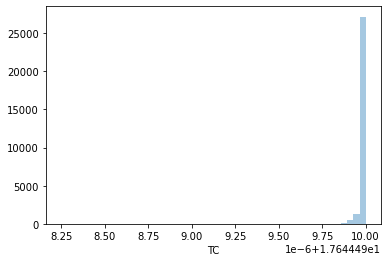

In [19]:
data['TC'] = data.precio_pesos / data.precio_usd

data.loc[:,['precio', 'precio_usd', 'precio_pesos', 'TC']].describe()

sns.distplot(data['TC'], kde= False)

In [20]:
# Todos los valores que no tienen precio, tampoco tienen ningun dato en las columnas de precio y precio_usd

print(data[(data.precio.isnull()) & (data.precio_usd.isnull())].shape[0])
print(data[data.precio.isnull()].shape[0])

3298
3298


### 2. Lat y lon

In [4]:
# importamos el achivo
data_location = "../geo2.csv"
datageo = pd.read_csv(data_location,  sep=';')

datageo.geonameid.astype(float)

FileNotFoundError: [Errno 2] File ../geo2.csv does not exist: '../geo2.csv'

In [ ]:
data = pd.merge(data, datageo, how = "left", left_on = "geonames_id", right_on = "geonameid")
print(data.head(2))

data['lat'] = data["lat"].fillna("latitude", inplace = True) 
data['lon'] = data["lon"].fillna("longitude", inplace = True)

In [127]:
# Completamos con el promedio de cada barrio. Otra opción podría haber sido utilziar el baricentro del barrio, pero no tenía ganas de buscarlo

lat_prom = data.groupby('barrio')['lat'].transform(lambda x: x.mean())
lon_prom = data.groupby('barrio')['lon'].transform(lambda x: x.mean())

data['lat'] = data.lat.fillna(lat_prom)
data['lon'] = data.lon.fillna(lon_prom)

### 3. Análisis sobre la superficie de los inmuebles

,lat,lon,precio,moneda,precio_pesos,precio_usd,sup_total,sup_cubierta,precio_usd_m2,precio_m2,piso,expensas,descripcion,titulo,ambientes
120031,-34.639019,-58.504279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 1019-V351 ubicado en: GUARDIA NACIONAL...,EXCLUSIVO SEMIPISOS SOBRE BOULEVARD DE 3 AMB,3.0
42611,-34.621237,-58.525722,100000.0,USD,1764450.0,100000.0,NaN,NaN,NaN,NaN,NaN,3000.0,CODIGO: 2461-1A852 ubicado en: Tinogasta al 58...,"2 AMBIENTES AL FRENTE EN PB , MUY LUMINOSO",0.0
29676,-34.648108,-58.516044,99000.0,USD,1746805.5,99000.0,NaN,NaN,NaN,NaN,NaN,NaN,CODIGO: 3 ubicado en: Cafayate - Publicado p...,Hermoso ph de 2 ambientes,2.0
35118,-34.585318,-58.438656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ubicado sobre la calle que le da su nombre, el...",Palacio Cabrera,NaN
19649,-34.666860,-58.488961,255000.0,USD,4499347.5,255000.0,NaN,NaN,NaN,NaN,NaN,NaN,"Venta de Casa 4 AMBIENTES en Villa Lugano, Cap...",CASA EN VENTA,4.0
43014,-34.643838,-58.515089,98000.0,USD,1729161.0,98000.0,NaN,NaN,NaN,NaN,NaN,NaN,"Venta - Departamento - Argentina, Buenos Aires...",Departamento en Venta ubicado en Liniers,2.0
21788,-34.612775,-58.500575,289000.0,USD,5099260.5,289000.0,147.0,NaN,1965.986395,NaN,NaN,NaN,"Venta de Casa 4 AMBIENTES en Villa Devoto, Cap...",CASA EN VENTA,4.0
68005,-34.602279,-58.397065,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,AVISO LEGAL: Las descripciones arquitectónicas...,Departamento en Once,NaN
113121,-34.597859,-58.426035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ubicación: Ubicado en el límite de los barrios...,Estado de Israel 4272,1.0
108200,-34.620308,-58.463779,121000.0,USD,2134984.5,121000.0,51.0,NaN,2372.549020,NaN,NaN,NaN,...,Departamento - Flores,2.0


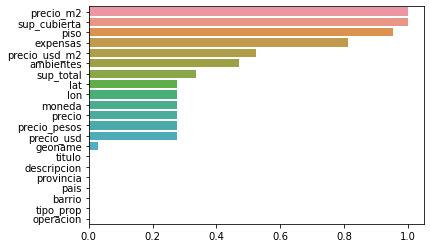

In [21]:
miss = data[data.sup_cubierta.isnull()].isnull().sum() / data[data.sup_cubierta.isnull()].shape[0]
miss.sort_values(ascending=False, inplace = True)

sns.barplot(y = miss.index, x= miss)

data[data.sup_cubierta.isnull()].sample(10).iloc[:,6:]

In [23]:
data['prueba'] = data.sup_cubierta/data.sup_total
data.groupby(['tipo_prop', 'barrio'])['sup_total'].mean()

data['prueba2'] = data.groupby(['tipo_prop', 'barrio'])['prueba'].transform(lambda x: x.mean())
data['sup_total_2'] = data.sup_total.fillna(data.sup_cubierta / data.prueba2)
data['sup_cubierta_2'] = data.sup_cubierta.fillna(data.sup_total * data.prueba2)


print(data.sup_total_2.isnull().sum())
print(data.sup_cubierta_2.isnull().sum())
data.loc[:,['tipo_prop', 'barrio', 'sup_total', 'sup_cubierta', 'sup_total_2', 'sup_cubierta_2']]

790
786


,tipo_prop,barrio,sup_total,sup_cubierta,sup_total_2,sup_cubierta_2
0,PH,Mataderos,55.0,40.0,55.0,40.000000
2,apartment,Mataderos,55.0,55.0,55.0,55.000000
3,PH,Liniers,NaN,NaN,NaN,NaN
7,apartment,Belgrano,45.0,40.0,45.0,40.000000
8,apartment,Belgrano,65.0,60.0,65.0,60.000000
...,...,...,...,...,...,...
121160,apartment,Belgrano,157.0,NaN,157.0,138.757336
121209,apartment,Belgrano,157.0,NaN,157.0,138.757336
121215,apartment,Belgrano,113.0,93.0,113.0,93.000000
121217,apartment,Villa Urquiza,46.0,39.0,46.0,39.000000


In [24]:
data = data.drop(['sup_total', 'sup_cubierta'], axis = 1)
data = data.rename({'sup_total_2': 'sup_total', 'sup_cubierta_2': 'sup_cubierta'}, axis = 1)

### 4. Análisis sobre los precio por m2

In [26]:
data['precio_x_m2_usd'] = data.precio_usd / data.sup_total

data['precio_prom'] = data.groupby(['barrio', 'tipo_prop'])['precio_x_m2_usd'].transform(lambda x: x.mean())

data['precio_x_m2_usd'] = data.precio_x_m2_usd.fillna(data.precio_prom)

In [27]:
data['precio_usd'] = data.precio_usd.fillna(data.sup_total * data.precio_x_m2_usd)

### 5. Dataset limpio

In [125]:
data.columns

data.drop(['operacion', 'provincia', 'geoname', 'precio', 'moneda', 'precio_pesos', 
           'precio_usd_m2', 'precio_m2', 'expensas', 'descripcion', 'titulo', 'TC', 
           'prueba', 'prueba2', 'precio_prom'], axis = 1)

,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,ambientes,sup_total,sup_cubierta,precio_x_m2_usd,subtes,bicis,comisarias
0,PH,Mataderos,Argentina,-34.661824,-58.508839,62000.0,NaN,2.0,55.0,40.000000,1127.272727,0,0,851.917314
2,apartment,Mataderos,Argentina,-34.652262,-58.522982,72000.0,3.0,2.0,55.0,55.000000,1309.090909,0,0,2410.061423
3,PH,Liniers,Argentina,-34.647797,-58.516424,95000.0,0.0,3.0,NaN,NaN,1466.775587,0,0,1529.449067
7,apartment,Belgrano,Argentina,-34.559873,-58.443362,138000.0,NaN,1.0,45.0,40.000000,3066.666667,0,0,566.139534
8,apartment,Belgrano,Argentina,-34.559873,-58.443362,195000.0,NaN,NaN,65.0,60.000000,3000.000000,0,0,566.139534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121160,apartment,Belgrano,Argentina,-34.563685,-58.442683,410000.0,NaN,NaN,157.0,138.757336,2611.464968,0,0,995.816631
121209,apartment,Belgrano,Argentina,-34.563685,-58.442683,410000.0,NaN,NaN,157.0,138.757336,2611.464968,0,0,995.816631
121215,apartment,Belgrano,Argentina,NaN,NaN,870000.0,2.0,NaN,113.0,93.000000,7699.115044,0,0,NaN
121217,apartment,Villa Urquiza,Argentina,-34.570639,-58.475596,131500.0,NaN,1.0,46.0,39.000000,2858.695652,0,0,276.121605


# ANEXO I: Imputer from sklearn library

Funciona bien para algunas variables que son numéricas. Es neceasrio pasar todos lso datos categóricos a numéricos para que los tome

In [100]:
data['tipo_prop'] = data.tipo_prop.astype('category')
data['barrio'] = data.barrio.astype('category')
data['moneda'] = data.moneda.astype('category')

probamos = data.drop(['operacion', 'pais', 'descripcion', 'titulo', 'provicnia'], axis = 1)

probamos['tipo_prop'] = probamos.tipo_prop.cat.codes
probamos['barrio'] = probamos.barrio.cat.codes
probamos['moneda'] = probamos.moneda.cat.codes

In [109]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=50, random_state=0)

imp.fit(probamos)

veamos = pd.DataFrame(imp.transform(probamos))

veamos.columns = probamos.columns
veamos.index = probamos.index
veamos['barrio'] = data.barrio
veamos['moneda'] = data.moneda
veamos['tipo_prop'] = data.tipo_prop
veamos

,tipo_prop,barrio,geoname,lat,lon,precio,moneda,precio_pesos,precio_usd,sup_total,sup_cubierta,precio_usd_m2,precio_m2,piso,expensas,ambientes,prueba,prueba2,sup_total_2
0,PH,Mataderos,3430787.0,-34.661824,-58.508839,62000.0,USD,1093959.00,62000.0,55.000000,40.000000,1127.272727,1550.000000,11.095845,31140.543496,2.000000,0.727273,0.802674,55.000000
2,apartment,Mataderos,3430787.0,-34.652262,-58.522982,72000.0,USD,1270404.00,72000.0,55.000000,55.000000,1309.090909,1309.090909,20.370324,30665.993410,2.000000,1.000000,0.840668,55.000000
3,PH,Liniers,3431333.0,-34.647797,-58.516424,95000.0,USD,1676227.50,95000.0,312.516485,-151.391508,60234.945126,348530.637884,40.707655,9881.278972,3.000000,-15.231229,0.724995,309.970121
7,apartment,Belgrano,3436077.0,-34.559873,-58.443362,138000.0,USD,2434941.00,138000.0,45.000000,40.000000,3066.666667,3450.000000,8.761273,10575.612225,1.000000,0.888889,0.883805,45.000000
8,apartment,Belgrano,3436077.0,-34.559873,-58.443362,195000.0,USD,3440677.50,195000.0,65.000000,60.000000,3000.000000,3250.000000,5.464668,4757.921919,2.284650,0.923077,0.883805,65.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121160,apartment,Belgrano,3436077.0,-34.563685,-58.442683,410000.0,USD,7234245.00,410000.0,157.000000,112.498727,2611.464968,-231195.958417,9.486078,6300.000000,3.180385,4.506793,0.883805,157.000000
121209,apartment,Belgrano,3436077.0,-34.563685,-58.442683,410000.0,USD,7234245.00,410000.0,157.000000,112.498727,2611.464968,-231195.958417,9.486078,6300.000000,3.180385,4.506793,0.883805,157.000000
121215,apartment,Belgrano,3436077.0,-34.690358,-58.524300,870000.0,USD,15350715.00,870000.0,113.000000,93.000000,7699.115044,9354.838710,38.259387,10000.000000,6.722078,0.823009,0.883805,113.000000
121217,apartment,Villa Urquiza,3433775.0,-34.570639,-58.475596,131500.0,USD,2320251.75,131500.0,46.000000,39.000000,2858.695652,3371.794872,11.557279,18868.697075,1.000000,0.847826,0.854165,46.000000


## ANEXO II: Incorporar data de transporte público

In [31]:
subte = pd.read_csv('estaciones-de-subte.csv')
subte.head(2)

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H


In [62]:
lista = []

for i in data.index:
    
    dist_lat = (subte.lat - data.lat[i]) * 111000
    dist_lon = (subte.long - data.lon[i]) * 111000
    norma = (dist_lat ** 2 + dist_lon ** 2) ** (1/2)
    
    cantidad_subte = len(norma[norma < 500])
    
    lista.append(cantidad_subte)

cantidad_subte = pd.Series(lista, index = data.index, name = 'subtes')

data = data.join(cantidad_subte)

In [60]:
bicis = pd.read_csv('estaciones_sistema_viejo.csv')
bicis.head(2)

,id_estacion,nombre_estacion,long_estacion,lat_estacion,domicilio_estacion,tipo_estacion,observaciones,horario_estacion
0,1.0,Facultad de Derecho,-58.392452,-34.583133,Av. Pres.Figueroa Alcorta y Juan A.Bibiloni,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas
1,2.0,Retiro,-58.374822,-34.592589,Av. Dr.Jose Ramos Mejia y Del Libertador Av,AUTOMÁTICA,Abril 2015 (pasó de ser Manual a Automática),Estación automática: disponibilidad las 24 horas


In [63]:
lista = []

for i in data.index:
    
    dist_lat = (bicis.lat_estacion - data.lat[i]) * 111000
    dist_lon = (bicis.long_estacion - data.lon[i]) * 111000
    norma = (dist_lat ** 2 + dist_lon ** 2) ** (1/2)
    
    cantidad_bicis = len(norma[norma < 500])
    
    lista.append(cantidad_bicis)

cantidad_bicis = pd.Series(lista, index = data.index, name = 'bicis')

data = data.join(cantidad_bicis)

## ANEXO III: Incorporar data de Seguridad

In [64]:
comisarias = pd.read_csv('comisarias-policia-de-la-ciudad.csv')
comisarias.head(2)

,long,lat,id,nombre,calle,altura,calle2,direccion,telefonos,observaciones,observaciones_2,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.373245,-34.601906,1,Comisaria Vecinal 1-D,Lavalle,451,NaN,LAVALLE 451,4322-8033/8221,NaN,NaN,SAN NICOLAS,1,1047.0,C1047AAI
1,-58.424926,-34.628641,37,Comisaria Vecinal 5-B,Muñiz,1250,NaN,MUÑIZ 1250,4922-1229 /4922-3333,NaN,NaN,BOEDO,5,1255.0,C1255ACD


In [66]:
lista = []

for i in data.index:
    
    dist_lat = (comisarias.lat - data.lat[i]) * 111000
    dist_lon = (comisarias.long - data.lon[i]) * 111000
    norma = (dist_lat ** 2 + dist_lon ** 2) ** (1/2)
    
    comisaria_dist_min = min(norma)
    
    lista.append(comisaria_dist_min)

comisaria_mas_cerca = pd.Series(lista, index = data.index, name = 'comisarias')

data = data.join(comisaria_mas_cerca)